<a href="https://colab.research.google.com/github/yvkrishna/paddy_disease_classification/blob/master/Paddy_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/yvkrishna/paddy_disease_classification.git

Cloning into 'paddy_disease_classification'...
remote: Enumerating objects: 561, done.
remote: Counting objects: 100% (561/561), done.
remote: Compressing objects: 100% (541/541), done.
remote: Total 561 (delta 40), reused 515 (delta 20), pack-reused 0
Receiving objects: 100% (561/561), 41.34 MiB | 30.90 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os 
from os import path
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from scipy import interp
from itertools import cycle
import pandas as pd
import seaborn as sn
from google.colab import files

In [3]:
# importing all tensorflow modules 
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, ReLU, Dropout, Dense
from tensorflow.keras import Model

In [4]:
os.chdir('/content')

Numpy is used to manipulating and using arrays of data easily.

Pandas helps us to play with the data .

Matplotlib is used to visulaize the data.

In [5]:
os.chdir('paddy_disease_classification/rice_leaf_diseases')
path = os.getcwd()
training_classes = [f.name for f in os.scandir(path) if f.is_dir()]
print(training_classes)

['Brown spot', 'Bacterial leaf blight', 'Leaf smut']


Image Pre Processing Steps

In [6]:
def applyMedian(folder):
  ''' 
    Applies Meadian Filter to all the images in the given folder. 
    Args : 
      # img_loc: (str). : Image_dir in the current class.
      # img_save: (str). : Image_dir to save the images
      Folder : (str). : Image_directory
  '''
  previous_path = os.getcwd()
  os.chdir(folder)
  current_path = os.getcwd()

  for image in tqdm(list(os.listdir(current_path))):
    img = cv2.imread(image)
    # applies median filter to the image.
    median = cv2.medianBlur(img, 5)
    # saving the image by adding the blur feature.
    im = Image.fromarray(median)
    im.save(image)
  os.chdir(previous_path)

In [7]:
for folder in training_classes:
  applyMedian(folder)

100%|██████████| 40/40 [00:04<00:00,  8.45it/s]


In [8]:
os.chdir('/content')

In [9]:
base_dir = 'paddy_disease_classification'
train_dir = os.path.join(base_dir, 'rice_leaf_diseases')

In [10]:
train_bact_leaf_smut_dir = os.path.join(train_dir, 'Bacterial leaf blight')  # directory with our training cat pictures
train_brown_spot_dir = os.path.join(train_dir, 'Brown spot')  # directory with our training dog pictures
train_leaf_smut_dir = os.path.join(train_dir, 'Leaf smut')  # directory with our training dog pictures

In [11]:
num_bact_leaf_smut_tr = len(os.listdir(train_bact_leaf_smut_dir))
num_brown_spot_tr = len(os.listdir(train_brown_spot_dir))
num_leaf_smut_tr = len(os.listdir(train_leaf_smut_dir))

total_train = num_bact_leaf_smut_tr + num_brown_spot_tr + num_leaf_smut_tr\

In [12]:
print('total training Bacterial leaf blight images:', num_bact_leaf_smut_tr)
print('total training Brown spot images:', num_brown_spot_tr)
print('total training Leaf smut images:', num_leaf_smut_tr)
print("--")
print("Total training images:", total_train)

total training Bacterial leaf blight images: 40
total training Brown spot images: 40
total training Leaf smut images: 40
--
Total training images: 120


In [13]:
BATCH_SIZE = 20
IMG_SHAPE  = 299

In [14]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 120 images belonging to 3 classes.


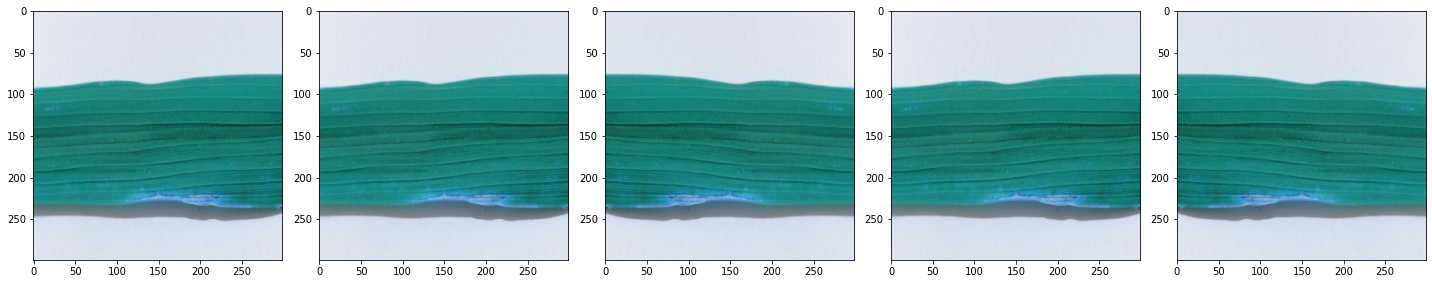

In [16]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [17]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=90)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

Found 120 images belonging to 3 classes.


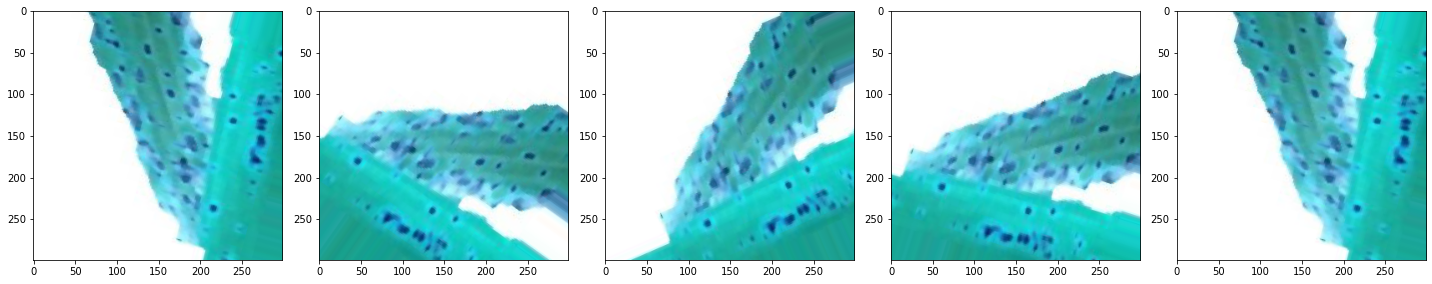

In [18]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [19]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


Found 120 images belonging to 3 classes.


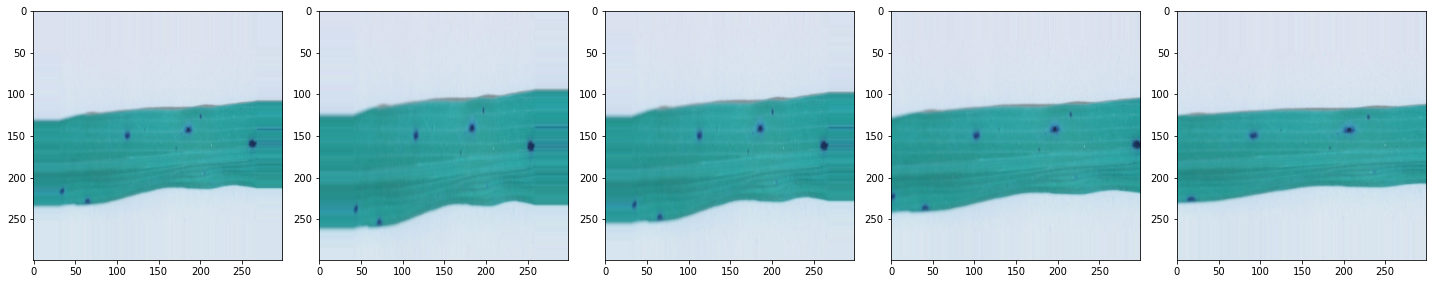

In [20]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [21]:
image_gen = ImageDataGenerator(rescale=1./255, shear_range=0.2)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 120 images belonging to 3 classes.


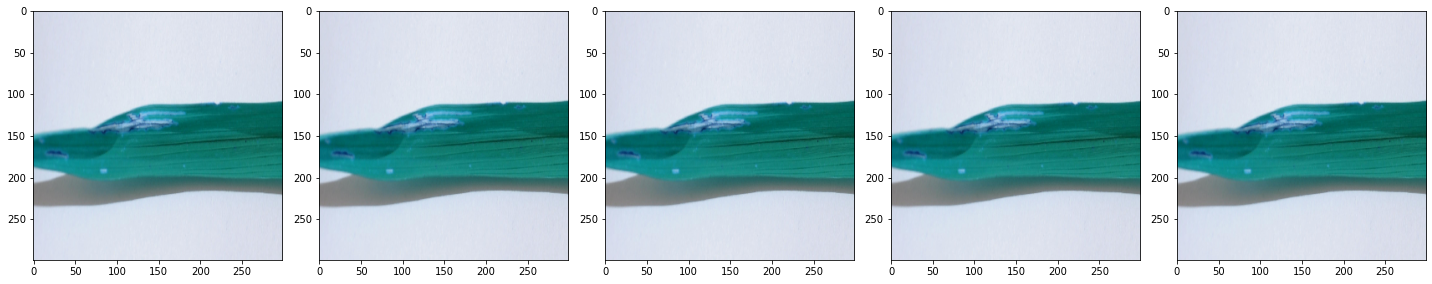

In [22]:
augmented_images = [train_data_gen[0][0][6] for i in range(5)]
plotImages(augmented_images)

In [23]:
# Putting All Together

image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='categorical')

Found 120 images belonging to 3 classes.


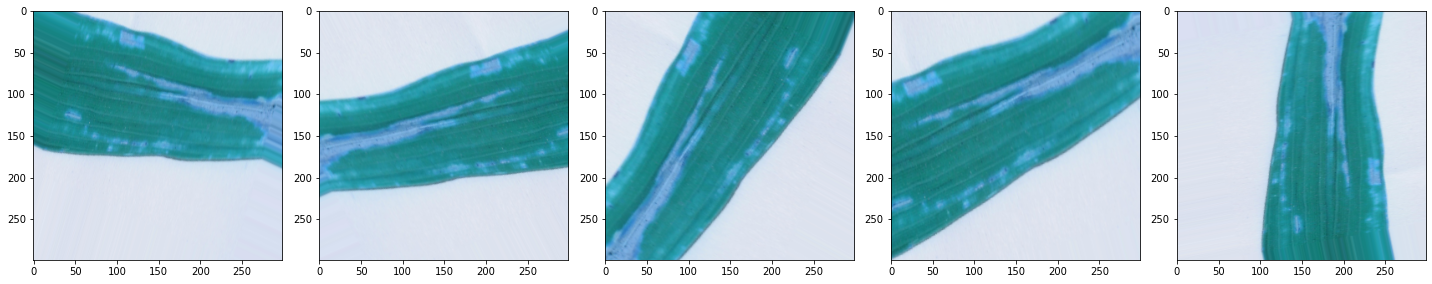

In [24]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [25]:
# rotate = plt.imread('Rotation.png')
# zoom = plt.imread('Zoom.png')
# flipping = plt.imread('flipping.png')

# plt.figure(num=None, figsize=(20,20), dpi=40, facecolor='w', edgecolor='k')

# plt.subplot(3,1,1)
# plt.imshow(rotate,aspect='auto')
# plt.title('Rotation',fontsize=40)
# plt.xticks([])
# plt.yticks([])
# plt.subplot(3,1,2)
# plt.imshow(zoom,aspect='auto')
# plt.title('Zoom',fontsize=40)
# plt.xticks([])
# plt.yticks([])
# plt.subplot(3,1,3)
# plt.imshow(flipping,aspect='auto')
# plt.title('Flipping',fontsize=40)
# plt.xticks([])
# plt.yticks([])

In [26]:
# Deenin in reference ga ikkade unchu. Dont change the code
# img = cv2.imread('leaf.JPG')
# leaf_img = plt.imread('leaf.JPG')
# median = cv2.medianBlur(img, 5)
# compare = np.concatenate((img, median), axis=1) #side by side comparison
# plt.subplot(1,2,1)
# plt.imshow(leaf_img,aspect='auto')
# plt.subplot(1,2,2)
# plt.imshow(median,aspect='auto')

In [27]:
# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(10))

In [28]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# history = model.fit(train_images, train_labels, epochs=10, 
#                     validation_data=(test_images, test_labels))

In [29]:
# Pre trained model 
inception_resnet_V2_pre_trained = InceptionResNetV2(include_top=True, weights='imagenet', pooling=None)

225214464/225209952 [==============================] - 2s 0us/step


In [30]:
for layer in inception_resnet_V2_pre_trained.layers:
    layer.trainable = True

predictions = Dense(3, activation='softmax')(inception_resnet_V2_pre_trained.output)
inception_resnet_V2 = Model(inputs=inception_resnet_V2_pre_trained.input, outputs=predictions)

In [31]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.9999, epsilon=1e-08,
    amsgrad=True, name='Adam' )

inception_resnet_V2.compile(
  optimizer=adam,
  loss='categorical_crossentropy',
  metrics=['accuracy',tf.keras.metrics.AUC()])

EPOCHS = 30
history_inception_resnet_v2 = inception_resnet_V2.fit(
    train_data_gen,
    epochs=EPOCHS,
    batch_size=10
)

Epoch 1/30
6/6 [==============================] - 5s 794ms/step - loss: 1.0980 - accuracy: 0.4417 - auc: 0.5183
Epoch 2/30
6/6 [==============================] - 6s 918ms/step - loss: 1.0971 - accuracy: 0.4250 - auc: 0.5478
Epoch 3/30
6/6 [==============================] - 6s 933ms/step - loss: 1.0966 - accuracy: 0.5083 - auc: 0.5699
Epoch 4/30
6/6 [==============================] - 5s 881ms/step - loss: 1.0968 - accuracy: 0.4750 - auc: 0.5540
Epoch 5/30
6/6 [==============================] - 6s 930ms/step - loss: 1.0967 - accuracy: 0.5667 - auc: 0.5164
Epoch 6/30
6/6 [==============================] - 5s 896ms/step - loss: 1.0950 - accuracy: 0.5583 - auc: 0.6097
Epoch 7/30
6/6 [==============================] - 5s 884ms/step - loss: 1.0938 - accuracy: 0.6417 - auc: 0.6152
Epoch 8/30
6/6 [==============================] - 5s 902ms/step - loss: 1.0926 - accuracy: 0.6333 - auc: 0.6567
Epoch 9/30
6/6 [==============================] - 5s 910ms/step - loss: 1.0909 - accuracy: 0.7167 - auc:

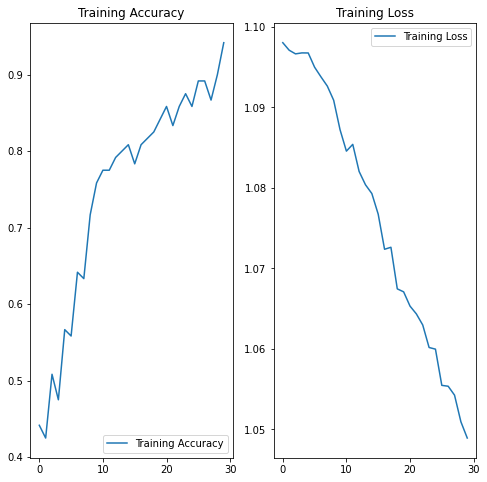

In [32]:
acc = history_inception_resnet_v2.history['accuracy']

loss = history_inception_resnet_v2.history['loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [33]:
# saving the model

export_path_keras = "./model.h5"
print(export_path_keras)

inception_resnet_V2.save(export_path_keras)

./model.h5


In [34]:
retrain = tf.keras.models.load_model(export_path_keras)

In [35]:
EPOCHS = 10
history = reloaded.fit(train_data_gen,
                    epochs=EPOCHS,
                    batch_size=10)

NameError: ignored

In [ ]:
acc = history.history['accuracy']

loss = history.history['loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [ ]:
!unzip PaddyNet.zip

In [ ]:
reload_sm_keras = tf.keras.models.load_model(
  export_path_sm,
  custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

In [ ]:
# export_path_sm = "./inception_resnet_v2"
# print(export_path_sm)

# tf.saved_model.save(model, export_path_sm)

In [ ]:
# !zip -r /content/PaddyNet /content/paddynet
# files.download("PaddyNet.zip")

In [36]:
def Get_Results_Inception_Resnet_V2(folder):
  ''' 
    Generates results for Inception_Resnet_V2 model
      Folder : (str). : Image_directory
  '''
  previous_path = os.getcwd()
  os.chdir(folder)
  current_path = os.getcwd()
  predicts = []

  for image in tqdm(list(os.listdir(current_path))):
    # img = cv2.imread(image)
    # median = cv2.medianBlur(img, 5)
    # im = Image.fromarray(median)
    # im.save(image)

    img = keras.preprocessing.image.load_img(image, target_size=(299,299, 3))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    result_inception_resnet_v2['image_names'].append(image)
    predicts.append(inception_resnet_V2.predict(img)[0])

    if (folder=='Bacterial leaf blight'):
      result_inception_resnet_v2['ground_truths'].append(np.asarray([1,0,0]))
    elif (folder=='Brown spot'):
      result_inception_resnet_v2['ground_truths'].append(np.asarray([0,0,1]))
    else:
      result_inception_resnet_v2['ground_truths'].append(np.asarray([0,1,0]))
  
  result_inception_resnet_v2['predictions'].append(predicts)
  os.chdir(previous_path)

In [37]:
result_inception_resnet_v2 = {'predictions':[],'image_names':[],'ground_truths':[]}
os.chdir('paddy_disease_classification/testing')

for folder in training_classes:
  Get_Results_Inception_Resnet_V2(folder)

os.chdir('/content')
result_inception_resnet_v2['predictions'] = np.asarray(result_inception_resnet_v2['predictions']).reshape((15, 3))

100%|██████████| 5/5 [00:00<00:00,  8.39it/s]


In [38]:
print(np.asarray(result_inception_resnet_v2['ground_truths']))
print(np.asarray(result_inception_resnet_v2['predictions']))
print(np.asarray(result_inception_resnet_v2['ground_truths']).shape)
print(np.asarray(result_inception_resnet_v2['predictions']).shape)

[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]]
[[0.32333922 0.33774745 0.33891332]
 [0.32817763 0.3297221  0.34210023]
 [0.32108134 0.3503316  0.32858703]
 [0.3261454  0.3480641  0.32579052]
 [0.32927164 0.34192026 0.32880807]
 [0.35473692 0.33212456 0.31313854]
 [0.33295664 0.33545253 0.33159083]
 [0.35490912 0.33204728 0.31304362]
 [0.35464215 0.3321313  0.31322658]
 [0.33823368 0.33111048 0.33065587]
 [0.31073293 0.33401117 0.35525593]
 [0.33681077 0.31085226 0.352337  ]
 [0.33134997 0.329941   0.33870906]
 [0.31544763 0.33013657 0.35441583]
 [0.3384043  0.309539   0.3520567 ]]
(15, 3)
(15, 3)


In [39]:
pred = np.asarray(result_inception_resnet_v2['predictions'])
pred = np.argmax(pred, axis=1).reshape(-1)
pred = np.asarray(np.eye(len(training_classes),dtype=int)[pred])
print(pred)
print(pred.shape)

[[0 0 1]
 [0 0 1]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
(15, 3)


In [41]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(training_classes)):
    fpr[i], tpr[i], _ = roc_curve(result_inception_resnet_v2['ground_truths'][i], result_inception_resnet_v2['predictions'][i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.asarray(result_inception_resnet_v2['ground_truths']).ravel(),np.asarray(result_inception_resnet_v2['predictions']).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


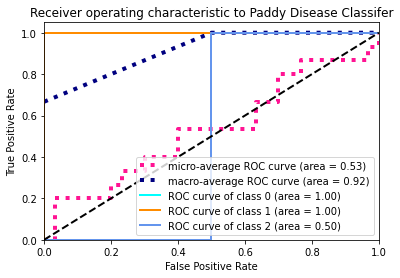

In [42]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(training_classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(training_classes)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(training_classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(training_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to Paddy Disease Classifer')
plt.legend(loc="lower right")
plt.show()


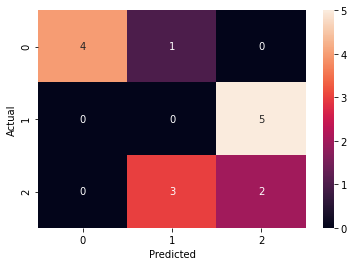

In [43]:
data = {'y_Actual': [np.where(r==1)[0][0] for r in np.asarray(result_inception_resnet_v2['ground_truths'])],
        'y_Predicted': [np.where(r==1)[0][0] for r in pred]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

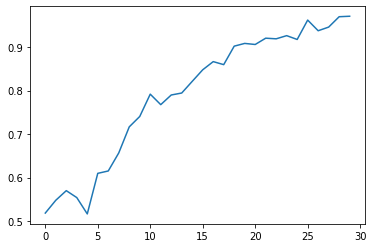

In [44]:
plt.plot(history_inception_resnet_v2.history['auc'])

In [ ]:
inception_resnet_V2.summary()

In [45]:
os.chdir('/content')

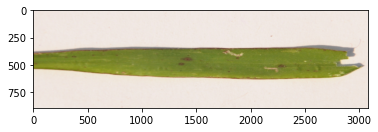

In [46]:
os.chdir('paddy_disease_classification/testing/Leaf smut')
test_image = plt.imread('DSC_0293.JPG')
img = keras.preprocessing.image.load_img('DSC_0293.JPG', target_size=(299,299, 3))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = tf.keras.applications.inception_v3.preprocess_input(img)
plt.imshow(test_image)
os.chdir('/content')

In [47]:
layer_name = 'block8_1_conv'

# Taking output from 'block8_1_conv'
layer_output = inception_resnet_V2.get_layer(layer_name).output

# Generating a substance model from the pre_trained_model.
# model with input layer of pre_trained_model and output layer of 'mixed_7a'
feature_extraction_model_1 = tf.keras.Model(inputs=inception_resnet_V2.input, outputs=layer_output)

# Extracting the features
result = feature_extraction_model_1.predict(img)
print(result.shape)
print(inception_resnet_V2.predict(img)[0])

(1, 8, 8, 2080)
[0.33681077 0.31085226 0.352337  ]


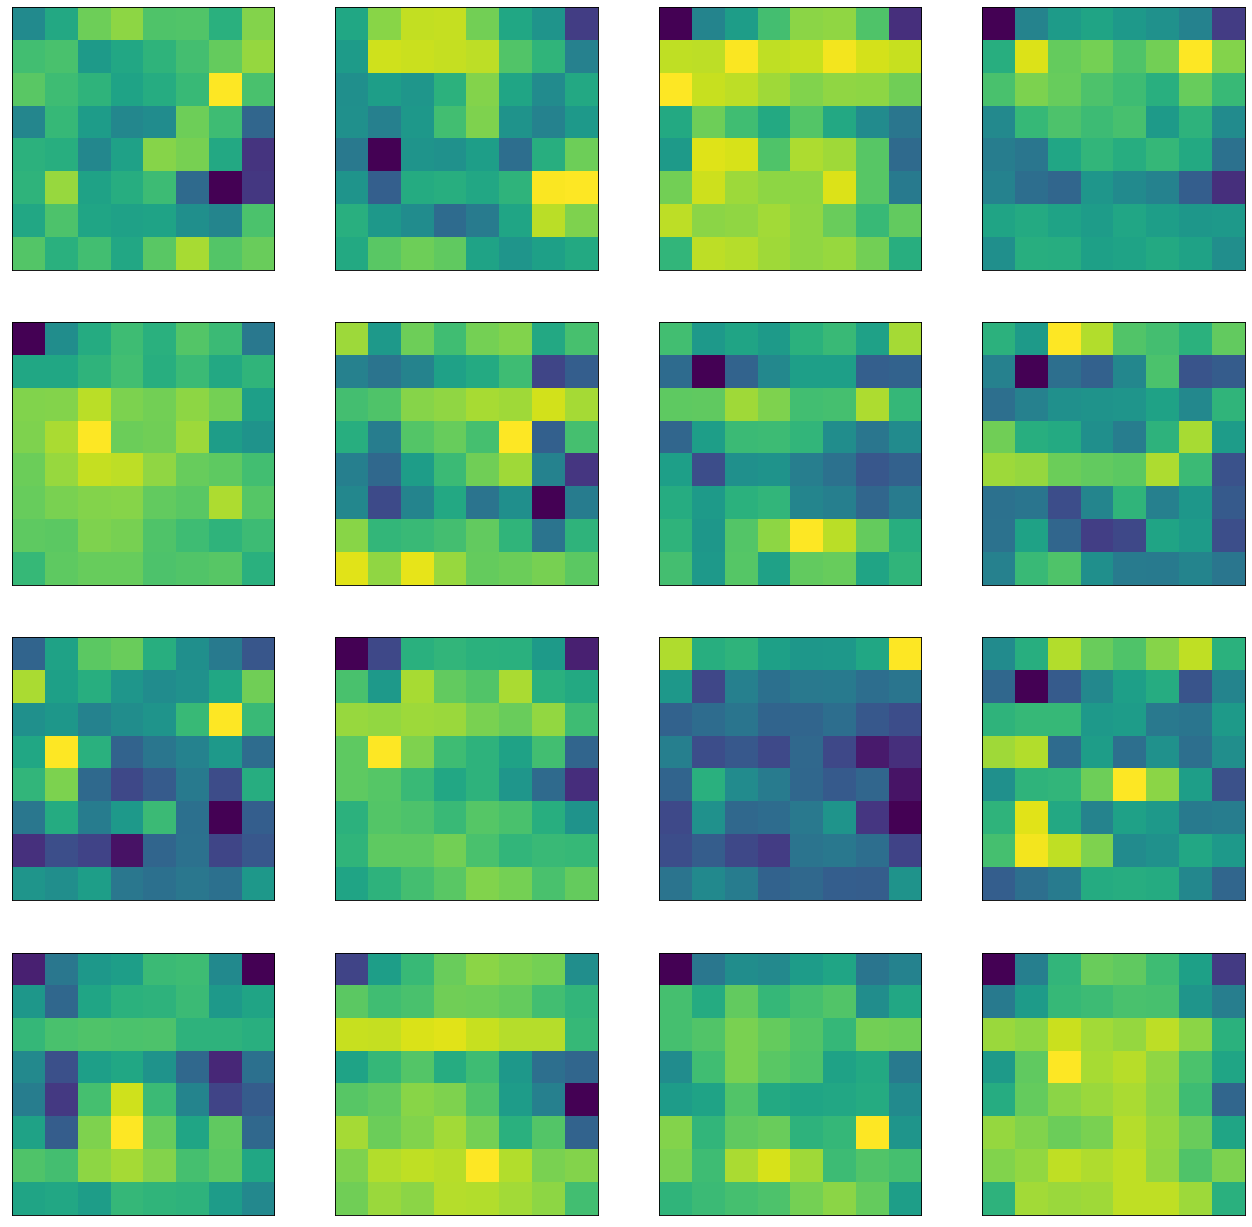

<Figure size 432x288 with 0 Axes>

In [48]:

'''	Plotting Various Features obtained from feature_extraction_model. '''
plot_limit = 4
index = 1
i=1500
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for _ in range(plot_limit):
	for _ in range(plot_limit):
		# specify subplot and turn of axis
		ax = plt.subplot(plot_limit, plot_limit, index)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(result[0, :, :, i-1])
		index += 1;i-=1
# show the figure
plt.show()
# Saving the Plot for future reference.
plt.savefig('Activations1.png')

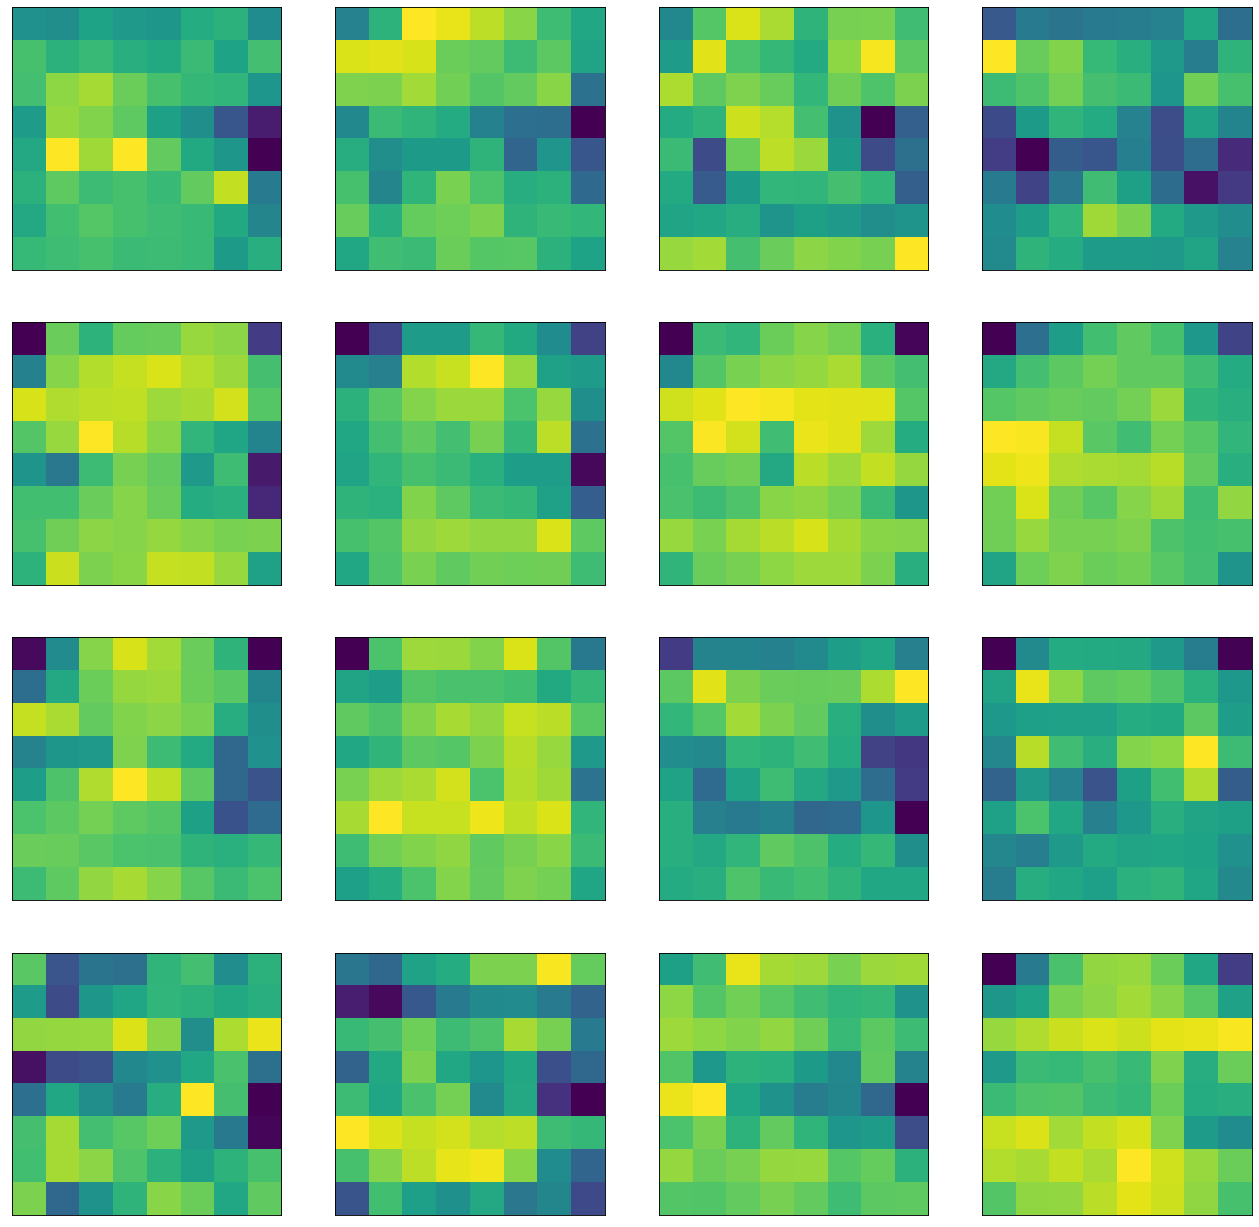

<Figure size 432x288 with 0 Axes>

In [49]:
# PLoting various features from the feature_extraction_model
plot_limit = 4
index = 1
layer_no = 1087
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for _ in range(plot_limit):
	for _ in range(plot_limit):
		# specify subplot and turn of axis
		ax = plt.subplot(plot_limit, plot_limit, index)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(result[0, :, :, layer_no],aspect="auto")
		index += 1;layer_no -= 1;
# show the figure
plt.show()
plt.savefig('Activations2.png')

In [50]:
# Pre trained model 
inception_V3_pre_trained = InceptionV3(include_top=True, weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [51]:
for layer in inception_V3_pre_trained.layers:
    layer.trainable = True

predictions = Dense(3, activation='softmax')(inception_V3_pre_trained.output)
inception_V3 = Model(inputs=inception_V3_pre_trained.input, outputs=predictions)

In [52]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.9999, epsilon=1e-08,
    amsgrad=True, name='Adam' )

inception_V3.compile(
  optimizer=adam,
  loss='categorical_crossentropy',
  metrics=['accuracy',tf.keras.metrics.AUC()])

EPOCHS = 30
history_inception_V3 = inception_V3.fit(
    train_data_gen,
    epochs=EPOCHS
)

Epoch 1/30
6/6 [==============================] - 5s 782ms/step - loss: 1.0982 - accuracy: 0.3667 - auc_1: 0.5197
Epoch 2/30
6/6 [==============================] - 5s 823ms/step - loss: 1.0980 - accuracy: 0.3417 - auc_1: 0.5302
Epoch 3/30
6/6 [==============================] - 5s 817ms/step - loss: 1.0980 - accuracy: 0.4333 - auc_1: 0.5086
Epoch 4/30
6/6 [==============================] - 5s 816ms/step - loss: 1.0967 - accuracy: 0.4500 - auc_1: 0.5669
Epoch 5/30
6/6 [==============================] - 5s 807ms/step - loss: 1.0965 - accuracy: 0.4917 - auc_1: 0.5537
Epoch 6/30
6/6 [==============================] - 5s 819ms/step - loss: 1.0964 - accuracy: 0.5333 - auc_1: 0.5822
Epoch 7/30
6/6 [==============================] - 5s 821ms/step - loss: 1.0953 - accuracy: 0.4917 - auc_1: 0.6216
Epoch 8/30
6/6 [==============================] - 5s 816ms/step - loss: 1.0948 - accuracy: 0.6000 - auc_1: 0.6185
Epoch 9/30
6/6 [==============================] - 5s 849ms/step - loss: 1.0939 - accurac

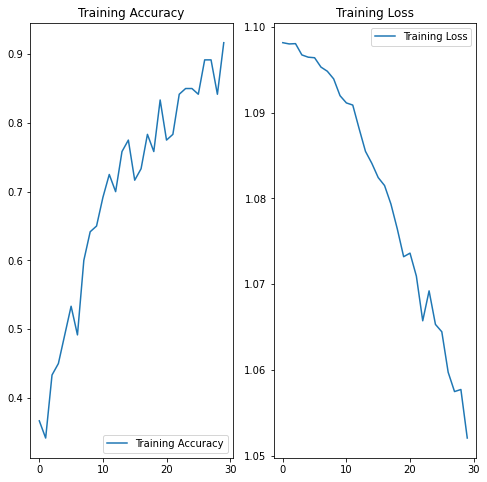

In [53]:
acc = history_inception_V3.history['accuracy']

loss = history_inception_V3.history['loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [ ]:
# # saving the model

# export_path_keras = "./model.h5"
# print(export_path_keras)

# model.save(export_path_keras)

In [ ]:
# export_path_sm = "./inception_V3"
# print(export_path_sm)

# tf.saved_model.save(model, export_path_sm)

In [ ]:
# !zip -r /content/PaddyNet /content/paddynet
# files.download("PaddyNet.zip")

In [56]:
def Get_Results_Inception_V3(folder):
  ''' 
    Generates results for Inception_Resnet_V2 model
      Folder : (str). : Image_directory
  '''
  previous_path = os.getcwd()
  os.chdir(folder)
  current_path = os.getcwd()
  predicts = []

  for image in tqdm(list(os.listdir(current_path))):
    # img = cv2.imread(image)
    # median = cv2.medianBlur(img, 5)
    # im = Image.fromarray(median)
    # im.save(image)

    img = keras.preprocessing.image.load_img(image, target_size=(299,299, 3))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    result_inception_v3['image_names'].append(image)
    predicts.append(inception_V3.predict(img)[0])

    if (folder=='Bacterial leaf blight'):
      result_inception_v3['ground_truths'].append(np.asarray([1,0,0]))
    elif (folder=='Brown spot'):
      result_inception_v3['ground_truths'].append(np.asarray([0,0,1]))
    else:
      result_inception_v3['ground_truths'].append(np.asarray([0,1,0]))
  
  result_inception_v3['predictions'].append(predicts)
  os.chdir(previous_path)

In [65]:
result_inception_v3 = {'predictions':[],'image_names':[],'ground_truths':[]}
os.chdir('paddy_disease_classification/testing')

for folder in training_classes:
  Get_Results_Inception_V3(folder)

os.chdir('/content')
result_inception_v3['predictions'] = np.asarray(result_inception_v3['predictions']).reshape((15, 3))

100%|██████████| 5/5 [00:00<00:00,  9.58it/s]


In [66]:
print(np.asarray(result_inception_v3['ground_truths']))
print(np.asarray(result_inception_v3['predictions']))
print(np.asarray(result_inception_v3['ground_truths']).shape)
print(np.asarray(result_inception_v3['predictions']).shape)

[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]]
[[0.3304017  0.33930635 0.3302919 ]
 [0.32755712 0.33755437 0.3348885 ]
 [0.3270802  0.33697283 0.33594698]
 [0.32962254 0.3348516  0.3355259 ]
 [0.32999593 0.33498228 0.33502173]
 [0.3363172  0.32855186 0.33513093]
 [0.33375713 0.3307206  0.3355223 ]
 [0.3477417  0.31962058 0.33263773]
 [0.32899594 0.3324849  0.33851916]
 [0.3358215  0.33525488 0.32892355]
 [0.34246087 0.32095233 0.33658683]
 [0.34318495 0.31019866 0.34661642]
 [0.32651916 0.31252202 0.3609588 ]
 [0.33552682 0.32896867 0.33550447]
 [0.3357641  0.32386628 0.34036955]]
(15, 3)
(15, 3)


In [67]:
pred = np.asarray(result_inception_v3['predictions'])
pred = np.argmax(pred, axis=1).reshape(-1)
pred = np.asarray(np.eye(len(training_classes),dtype=int)[pred])
print(pred)
print(pred.shape)

[[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]]
(15, 3)


In [70]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(training_classes)):
    fpr[i], tpr[i], _ = roc_curve(result_inception_v3['ground_truths'][i], result_inception_v3['predictions'][i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.asarray(result_inception_v3['ground_truths']).ravel(),np.asarray(result_inception_v3['predictions']).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


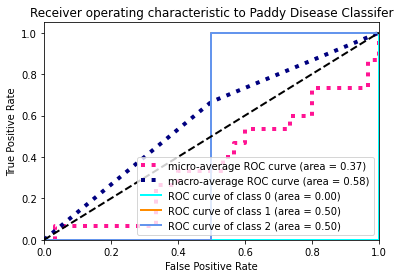

In [71]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(training_classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(training_classes)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(training_classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(training_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to Paddy Disease Classifer')
plt.legend(loc="lower right")
plt.show()


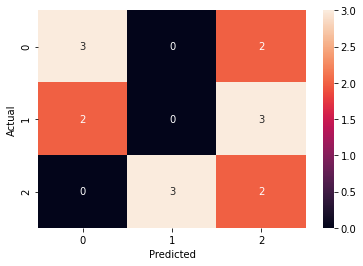

In [72]:
data = {'y_Actual': [np.where(r==1)[0][0] for r in np.asarray(result_inception_v3['ground_truths'])],
        'y_Predicted': [np.where(r==1)[0][0] for r in pred]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [74]:
plt.plot(history_inception_resnet_v2.history['auc_01'])

KeyError: ignored

In [ ]:
inception_V3.summary()

In [75]:
os.chdir('/content')

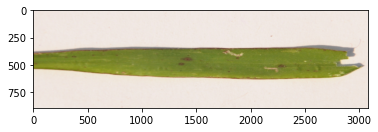

In [76]:
os.chdir('paddy_disease_classification/testing/Leaf smut')
test_image = plt.imread('DSC_0293.JPG')
img = keras.preprocessing.image.load_img('DSC_0293.JPG', target_size=(299,299, 3))
img = keras.preprocessing.image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = tf.keras.applications.inception_v3.preprocess_input(img)
plt.imshow(test_image)
os.chdir('/content')

In [77]:
layer_name = 'conv2d_231'

# Taking output from 'block8_1_conv'
layer_output = inception_V3.get_layer(layer_name).output

# Generating a substance model from the pre_trained_model.
# model with input layer of pre_trained_model and output layer of 'mixed_7a'
feature_extraction_model_2 = tf.keras.Model(inputs=inception_V3.input, outputs=layer_output)

# Extracting the features
result = feature_extraction_model_2.predict(img)
print(result.shape)

(1, 35, 35, 96)


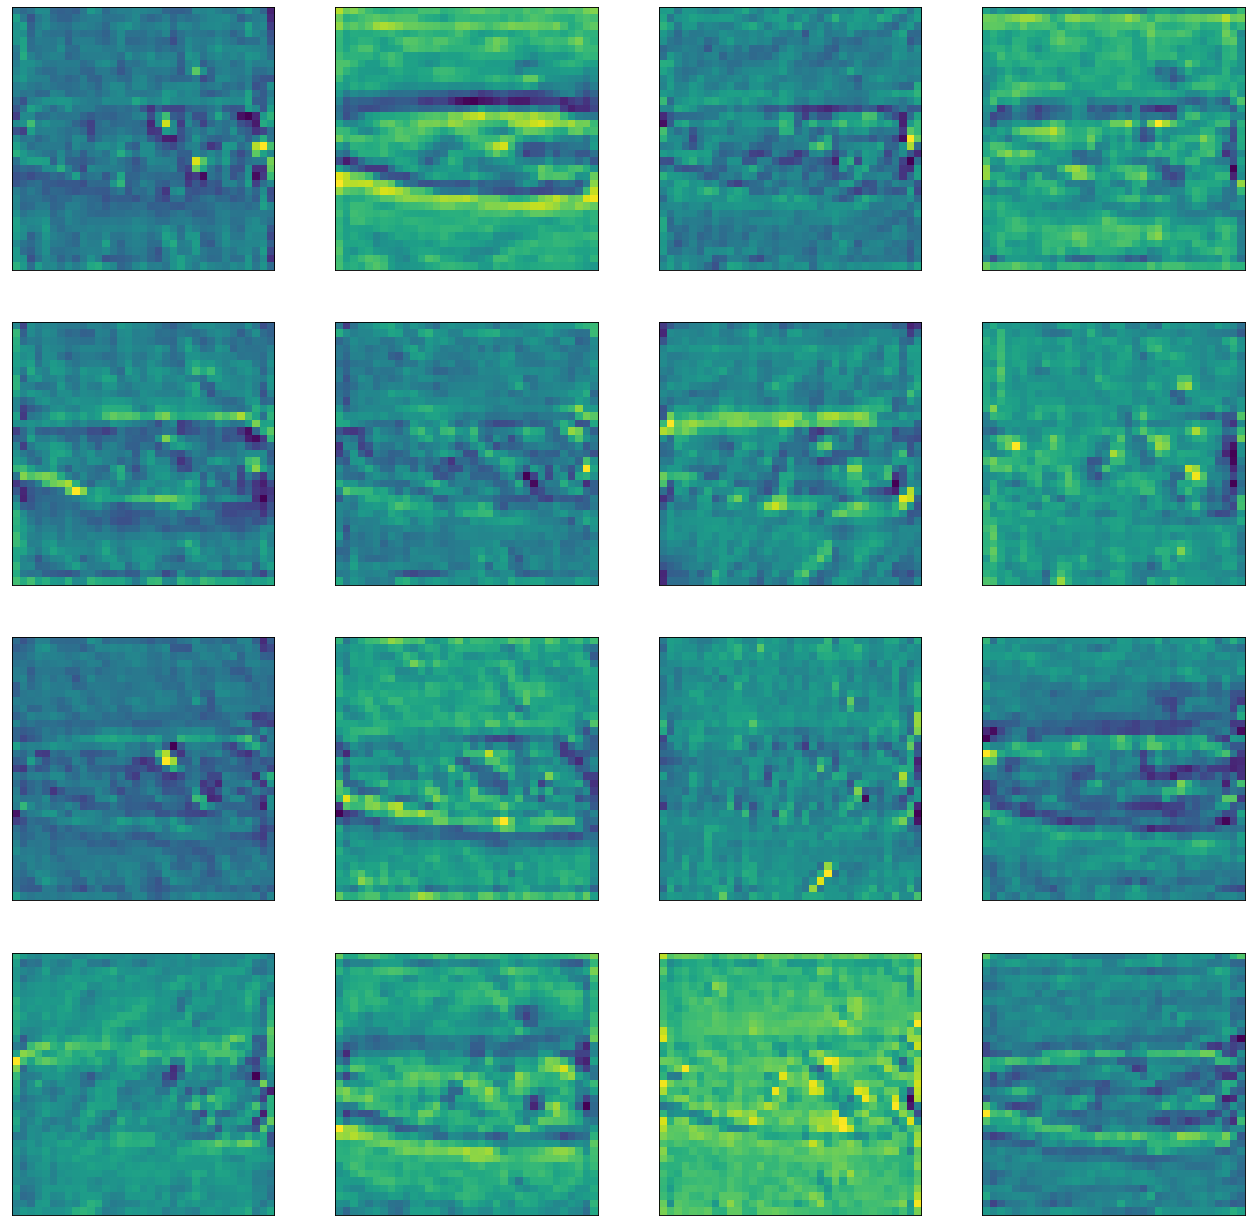

<Figure size 432x288 with 0 Axes>

In [78]:

'''	Plotting Various Features obtained from feature_extraction_model. '''
plot_limit = 4
index = 1
i=96
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for _ in range(plot_limit):
	for _ in range(plot_limit):
		# specify subplot and turn of axis
		ax = plt.subplot(plot_limit, plot_limit, index)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(result[0, :, :, i-1])
		index += 1;i-=1
# show the figure
plt.show()
# Saving the Plot for future reference.
plt.savefig('Activations1.png')

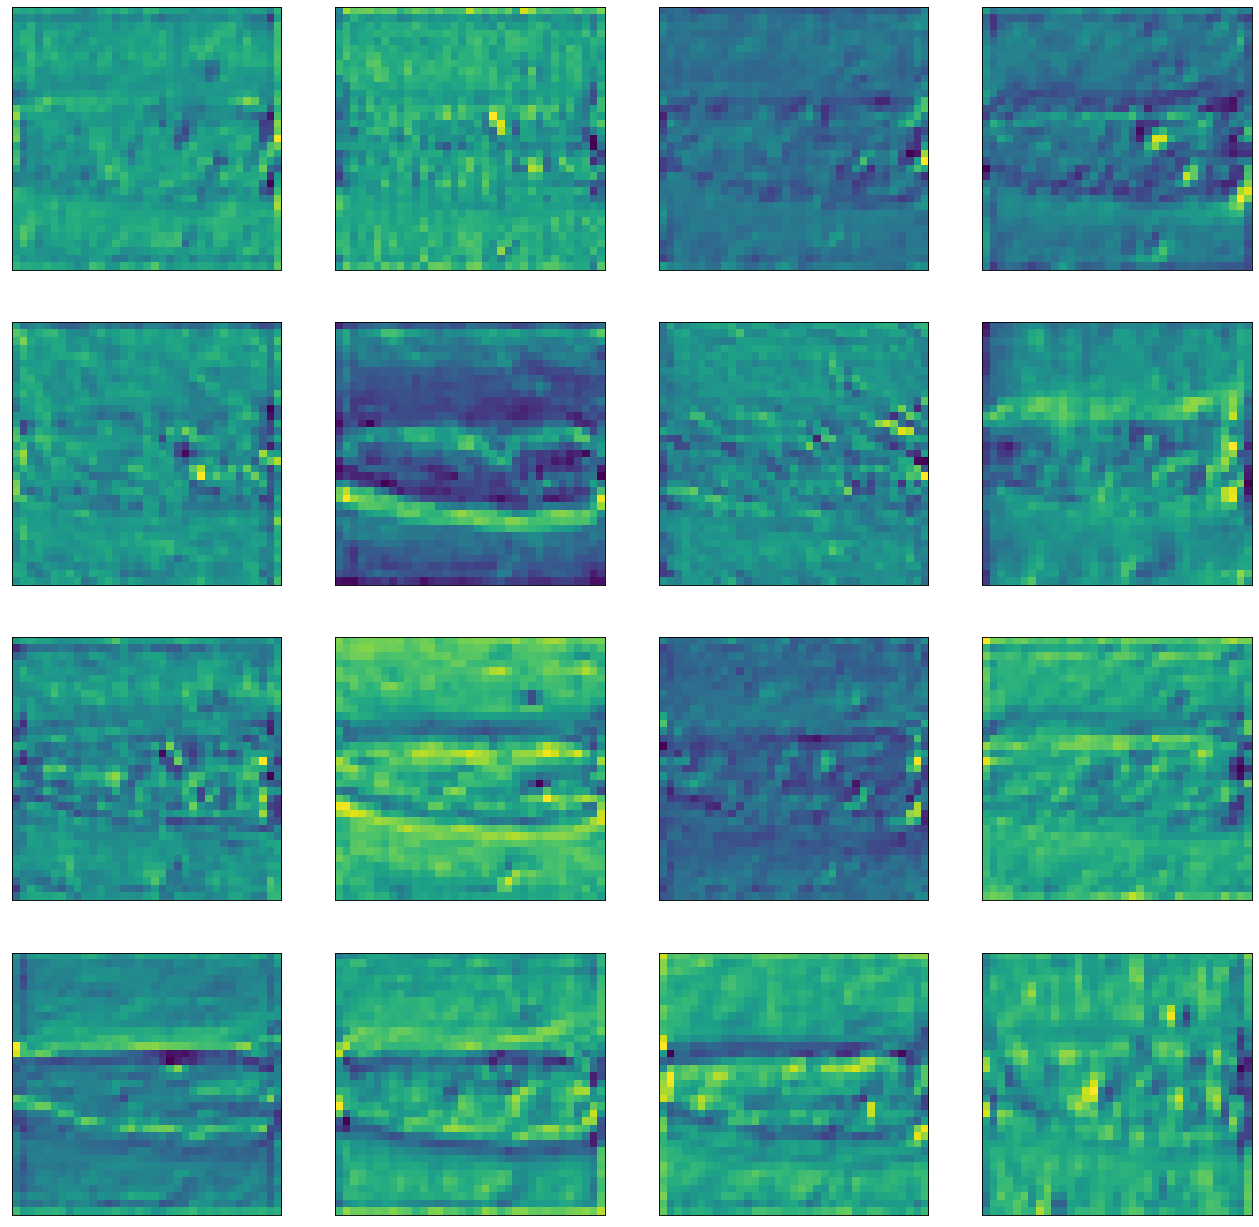

<Figure size 432x288 with 0 Axes>

In [79]:
# PLoting various features from the feature_extraction_model
plot_limit = 4
index = 1
layer_no = 32
plt.figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
for _ in range(plot_limit):
	for _ in range(plot_limit):
		# specify subplot and turn of axis
		ax = plt.subplot(plot_limit, plot_limit, index)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(result[0, :, :, layer_no],aspect="auto")
		index += 1;layer_no -= 1;
# show the figure
plt.show()
plt.savefig('Activations2.png')

In [82]:
# Pre trained model 
resnet_50_pre_trained = ResNet50(include_top=True, weights='imagenet')

In [83]:
for layer in resnet_50_pre_trained.layers:
    layer.trainable = True

predictions = Dense(3, activation='softmax')(resnet_50_pre_trained.output)
resnet_50 = Model(inputs=resnet_50_pre_trained.input, outputs=predictions)

In [84]:
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.9999, epsilon=1e-08,
    amsgrad=True, name='Adam' )

resnet_50.compile(
  optimizer=adam,
  loss='categorical_crossentropy',
  metrics=['accuracy',tf.keras.metrics.AUC()])

EPOCHS = 30
history_resnet_50 = resnet_50.fit(
    train_data_gen,
    epochs=EPOCHS
)

Epoch 1/30
6/6 [==============================] - 4s 736ms/step - loss: 1.0982 - accuracy: 0.4750 - auc_2: 0.4959
Epoch 2/30
6/6 [==============================] - 5s 828ms/step - loss: 1.0975 - accuracy: 0.4667 - auc_2: 0.5347
Epoch 3/30
6/6 [==============================] - 5s 838ms/step - loss: 1.0966 - accuracy: 0.5583 - auc_2: 0.5455
Epoch 4/30
6/6 [==============================] - 5s 838ms/step - loss: 1.0958 - accuracy: 0.6083 - auc_2: 0.5617
Epoch 5/30
6/6 [==============================] - 5s 846ms/step - loss: 1.0947 - accuracy: 0.6500 - auc_2: 0.6282
Epoch 6/30
6/6 [==============================] - 5s 804ms/step - loss: 1.0934 - accuracy: 0.6250 - auc_2: 0.6874
Epoch 7/30
6/6 [==============================] - 5s 825ms/step - loss: 1.0903 - accuracy: 0.6833 - auc_2: 0.7319
Epoch 8/30
6/6 [==============================] - 5s 865ms/step - loss: 1.0895 - accuracy: 0.6833 - auc_2: 0.7364
Epoch 9/30
6/6 [==============================] - 5s 817ms/step - loss: 1.0880 - accurac

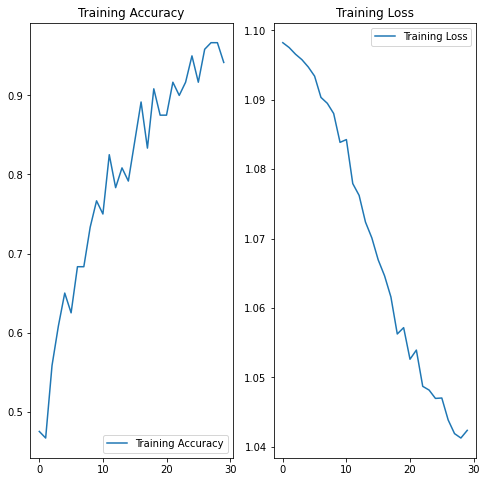

In [85]:
acc = history_resnet_50.history['accuracy']

loss = history_resnet_50.history['loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [ ]:
# # saving the model

# export_path_keras = "./model.h5"
# print(export_path_keras)

# model.save(export_path_keras)

In [ ]:
# export_path_sm = "./inception_V3"
# print(export_path_sm)

# tf.saved_model.save(model, export_path_sm)

In [ ]:
# !zip -r /content/PaddyNet /content/paddynet
# files.download("PaddyNet.zip")

In [86]:
def Get_Resnet_50(folder):
  ''' 
    Generates results for Inception_Resnet_V2 model
      Folder : (str). : Image_directory
  '''
  previous_path = os.getcwd()
  os.chdir(folder)
  current_path = os.getcwd()
  predicts = []

  for image in tqdm(list(os.listdir(current_path))):
    # img = cv2.imread(image)
    # median = cv2.medianBlur(img, 5)
    # im = Image.fromarray(median)
    # im.save(image)

    img = keras.preprocessing.image.load_img(image, target_size=(299,299, 3))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    result_resnet_50['image_names'].append(image)
    predicts.append(resnet_50.predict(img)[0])

    if (folder=='Bacterial leaf blight'):
      result_resnet_50['ground_truths'].append(np.asarray([1,0,0]))
    elif (folder=='Brown spot'):
      result_resnet_50['ground_truths'].append(np.asarray([0,0,1]))
    else:
      result_resnet_50['ground_truths'].append(np.asarray([0,1,0]))
  
  result_resnet_50['predictions'].append(predicts)
  os.chdir(previous_path)

In [90]:
result_resnet_50 = {'predictions':[],'image_names':[],'ground_truths':[]}
os.chdir('paddy_disease_classification/testing')

for folder in training_classes:
  Get_Resnet_50(folder)

os.chdir('/content')
result_resnet_50['predictions'] = np.asarray(result_resnet_50['predictions']).reshape((15, 3))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 10.48it/s]


In [91]:
print(np.asarray(result_resnet_50['ground_truths']))
print(np.asarray(result_resnet_50['predictions']))
print(np.asarray(result_resnet_50['ground_truths']).shape)
print(np.asarray(result_resnet_50['predictions']).shape)

[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]]
[[0.32180876 0.34625852 0.33193272]
 [0.3178135  0.35534883 0.3268377 ]
 [0.31910184 0.35175726 0.3291409 ]
 [0.3265777  0.33867    0.33475235]
 [0.32615665 0.34074208 0.33310133]
 [0.32228336 0.34304222 0.3346744 ]
 [0.3191736  0.35188854 0.3289379 ]
 [0.3214021  0.3465968  0.33200112]
 [0.3182998  0.3544037  0.3272965 ]
 [0.32132682 0.34692866 0.33174452]
 [0.31953886 0.35115793 0.32930323]
 [0.31789494 0.3552282  0.32687685]
 [0.31953165 0.35075504 0.32971337]
 [0.3191219  0.35262433 0.32825384]
 [0.31838286 0.3538975  0.32771963]]
(15, 3)
(15, 3)


In [92]:
pred = np.asarray(result_resnet_50['predictions'])
pred = np.argmax(pred, axis=1).reshape(-1)
pred = np.asarray(np.eye(len(training_classes),dtype=int)[pred])
print(pred)
print(pred.shape)

[[0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]]
(15, 3)


In [93]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(training_classes)):
    fpr[i], tpr[i], _ = roc_curve(result_resnet_50['ground_truths'][i], result_resnet_50['predictions'][i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(np.asarray(result_resnet_50['ground_truths']).ravel(),np.asarray(result_resnet_50['predictions']).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  import sys


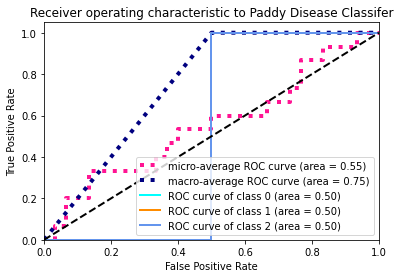

In [94]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(training_classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(training_classes)):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(training_classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(training_classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to Paddy Disease Classifer')
plt.legend(loc="lower right")
plt.show()


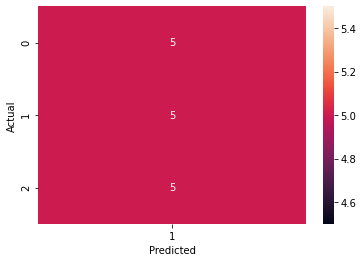

In [95]:
data = {'y_Actual': [np.where(r==1)[0][0] for r in np.asarray(result_resnet_50['ground_truths'])],
        'y_Predicted': [np.where(r==1)[0][0] for r in pred]
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
resnet_50.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

In [ ]:
os.chdir('/content')